## Import libraries and google drive (Select tensorflow version)

In [0]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
!cp  -r "../gdrive/My Drive/Pix2Pix" "."

Mounted at /gdrive


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from IPython.display import clear_output

## Select the folder

In [0]:
#Blanco y negro
path_train = "Pix2Pix/train/"
imgurls = !ls -1 {path_train}
for image in imgurls:
  img = PIL.Image.open(path_train + image)
  img = img.convert(mode='RGB')
  img.save(path_train + image)

In [0]:
##Directorio

#Blanco y negro
path_train = "Pix2Pix/train/"
#A color
path_target = "Pix2Pix/target/"
#Avances
checkpoint_folder = "Pix2Pix/checkpoints/"

imgurls = !ls -1 {path_train}
imgurls

['10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '18.jpg',
 '19.jpg',
 '1.jpg',
 '20.jpg',
 '21.jpg',
 '22.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

In [0]:
##Dividir test y entramiento
train_urls = imgurls[:21]
test_urls = imgurls[21:]
test_urls

['9.jpg']

## Data augmentation

In [0]:
##Data augmentation
img_size = 512


#Reescalar imagen
@tf.function
def resize(input_img, tar_img, img_size):
    input_img = tf.image.resize(input_img, [img_size, img_size])
    tar_img = tf.image.resize(tar_img, [img_size, img_size])
    
    return input_img, tar_img

#Normaliza las imagenes
def normalize(input_img, tar_img):
    input_img = (input_img/255.) - 1
    tar_img = (tar_img/255.) - 1
    return input_img, tar_img

def random_jitter(input_img, tar_img):
    input_img, tar_img = resize(input_img, tar_img, 572)

    #Apila las imagenes
    stacked_image = tf.stack([input_img, tar_img], axis=0)
    #Recorta
    cropped_image = tf.image.random_crop(stacked_image, size=[2, img_size, img_size, 3])
    
    input_img, tar_img = cropped_image[0], cropped_image[1]
    if tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        tar_img = tf.image.flip_left_right(tar_img)
    return input_img, tar_img

## Load the images

In [0]:
def load_image(filename, augment=True):
    input_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_train + filename)), tf.float32)[..., :3]
    tar_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_target + filename)), tf.float32)[..., :3]
    input_img, tar_img = resize(input_img, tar_img, img_size)
    if augment:
        input_img, tar_img = random_jitter(input_img, tar_img)
  
    input_img, tar_img = normalize(input_img, tar_img)
    return input_img, tar_img


##Funcion para cargar las imagenes para train y test
def load_train_image(filename):
    return load_image(filename)

def load_test_image(filename):
    return load_image(filename, False)

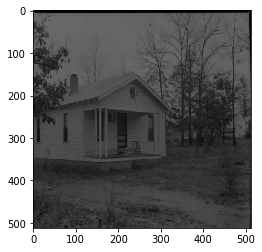

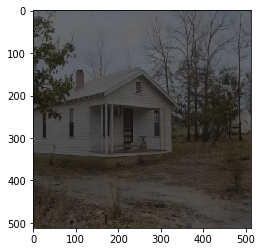

In [0]:
plt.figure()
plt.imshow(((load_train_image(train_urls[0])[0]) + 1. ) / 2.);
plt.figure()
plt.imshow(((load_train_image(train_urls[0])[1]) + 1. ) / 2.);

## Create the datasets

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(test_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

## Create the model

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

def downsample(filters, batch_norm=True):
  
  result = Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Conv
  result.add(Conv2D(filters=filters,strides=2, kernel_size=4, padding='same',
                    kernel_initializer=initializer, use_bias=not batch_norm))
  #Batch
  if batch_norm:
    result.add(BatchNormalization())
  #Activation LeakyRelu
  result.add(LeakyReLU())
  return result

def upsample(filters, dropout=True):
  result = Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)
  
  #Conv
  result.add(Conv2DTranspose(filters=filters,strides=2, kernel_size=4, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  #Batch
  if dropout:
    result.add(Droºpout(0.5))
  #Activation LeakyRelu
  result.add(ReLU())
  return result


def Generator():
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  inputs = Input(shape=[None, None, 3]) # (b, 256, 256, 64)
  
  down_stack = [
      downsample(64, batch_norm=False), # (b, 128, 128, 64)
      downsample(128), # (b, 64, 64, 128)
      downsample(256), # (b, 32, 32, 256)
      downsample(512), # (b, 16, 16, 512)
      downsample(512), # (b, 8, 8, 512)
      downsample(512), # (b, 4, 4, 512)
      downsample(512), # (b, 2, 2, 512)
      downsample(512)  # (b, 1, 1, 512)
  ]
  
  up_stack = [
      upsample(512), # (b, 2, 2, 1024)
      upsample(512), # (b, 4, 4, 1024)
      upsample(512), # (b, 8, 8, 1024)
      upsample(512, dropout=False), # (b, 16, 16, 1024)
      upsample(256, dropout=False), # (b, 32, 32, 512)
      upsample(128, dropout=False), # (b, 64, 64, 256)
      upsample(64, dropout=False), # (b, 128, 128, 128)

  ]

  last = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", kernel_initializer=initializer, 
                         activation='tanh')

  x = inputs
  s = []
  concat = Concatenate()
  for enc in down_stack:
    x = enc(x)
    s.append(x)
  s = reversed(s[:-1])
    
  for dec, sk in zip(up_stack, s):
    x = dec(x)
    x = concat([x, sk])    
 
  output = last(x)
  
  return Model(inputs=inputs, outputs=output)


def Discriminator():
  real_input = Input(shape=[None, None, 3], name="real_image")
  fake_input = Input(shape=[None, None, 3], name="fake_image")
  
  con = concatenate([real_input, fake_input])
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  dec1 = downsample(64, batch_norm=False)(con)
  dec2 = downsample(128)(dec1)
  dec3 = downsample(128)(dec2)
  dec4 = downsample(128)(dec3)
  
  output = Conv2D(filters=1, kernel_size=4, strides=1, kernel_initializer=initializer, padding='same')(dec4)
  return Model(inputs=[real_input, fake_input], outputs=output)

## Create the chekcpoint and the initializate the models

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

generator = Generator()
discriminator = Discriminator()
checkpoint_prefix = os.path.join(checkpoint_folder, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))

## Losses

In [0]:
## Crear perdidas
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discrimator_loss(disc_real_output, disc_generated_output):
  
  #Diferencia entre la imagen real y la detectada por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  #Diferencia entre la imagen generada y la detectada por el discriminador
  fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + fake_loss
  
  return total_disc_loss
  
  
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  #Error absoluto
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss =  gan_loss +(LAMBDA * l1_loss)
  
  return total_gen_loss

## Generate the images for the model

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img('Pix2Pix/output/' + save_filename + '.jpg', prediction[0,...])
    
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

## Training the model

In [0]:
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    output_image = generator(input_image, training=True)
    
    output_gen_discr = discriminator([output_image, input_image], training=True)
    
    output_target_discr = discriminator([target, input_image], training=True)

    discr_loss = discrimator_loss(output_target_discr, output_gen_discr)
    gen_loss = generator_loss(output_gen_discr,output_image, target)
    
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
  
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      imgi += 1
      print ('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(train_urls)))
      train_step (input_image, target)
      clear_output(wait=True)
      
      
    imgi = 0
    for inp, tar in test_dataset.take(1):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi +=1
      
    ##Saving
    if (epoch + 1) % 1 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

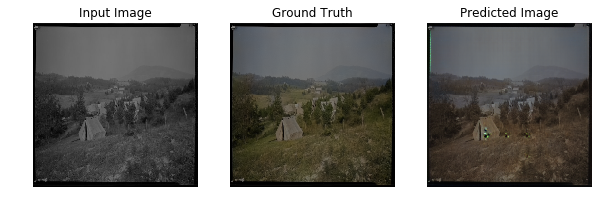

In [0]:
train(train_dataset, 300)